In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

try:
  from going_modular.going_modular import data_setup,engine
except:
  print(f"[INFO] counldn't find going modular.....installing it")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup,engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] counldn't find going modular.....installing it
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 32.31 MiB/s, done.
Resolving deltas: 100% (2657/2657), done.
Updating files: 100% (248/248), done.


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
import os
import zipfile
from pathlib import Path
import requests

data_path = Path('data/')
image_path = data_path/"pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory exists")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True,exist_ok=True)

  with open(data_path/'pizza_steak_sushi.zip','wb') as f:
    request=requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print('Downloading pizza,steak,sushi data...')
    f.write(request.content)

  with zipfile.ZipFile(data_path/'pizza_steak_sushi.zip','r') as zip_ref:
    print('unzipping file....')
    zip_ref.extractall(image_path)
  os.remove(data_path/'pizza_steak_sushi.zip')

Did not find data/pizza_steak_sushi directory, creating one...
unzipping file....


In [5]:
train_dir = image_path/'train'
test_dir = image_path/'test'

In [6]:
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [7]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[.485,.456,.406],
                                 std=[.229,0.224,.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),
  transforms.ToTensor(),
  normalize
])

In [8]:
from going_modular.going_modular import data_setup

train_dataloader,test_dataloader,class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                            test_dir=test_dir,
                                                                            transform=manual_transforms,
                                                                            batch_size=32)
train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e78e5df60c0>,
 ['pizza', 'steak', 'sushi'])

In [9]:
weight = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weight

EfficientNet_B0_Weights.IMAGENET1K_V1

In [10]:
auto_transformer = weight.transforms()
auto_transformer

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [11]:
train_dataloader,test_dataloader,class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                             test_dir=test_dir,
                                                                             transform=auto_transformer,
                                                                             batch_size=32)
train_dataloader,test_dataloader,class_names


(<torch.utils.data.dataloader.DataLoader at 0x7e7902e54560>,
 ['pizza', 'steak', 'sushi'])

In [12]:
# old method
# model = torchvision.models.efficientnet_b0(pretrained=True)

# new method
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 115MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [13]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [14]:
summary(model=model,
        input_size=(1,3,224,224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [15]:
for param in model.features.parameters():
  param.requires_grad = False

In [16]:
summary(model=model,
        input_size=(1,3,224,224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [17]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,out_features=len(class_names))
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [18]:
summary(model=model,
        input_size=(1,3,224,224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [31]:
from going_modular.going_modular import engine

torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results = engine.train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=5,
             device=device)

end_time=timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 0.5138 | train_acc: 0.9414 | test_loss: 0.5939 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.5641 | train_acc: 0.7812 | test_loss: 0.5866 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.5392 | train_acc: 0.8086 | test_loss: 0.5162 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.4983 | train_acc: 0.7969 | test_loss: 0.5108 | test_acc: 0.8561
Epoch: 5 | train_loss: 0.4181 | train_acc: 0.9531 | test_loss: 0.4959 | test_acc: 0.8456
Total training time: 148.830 seconds


In [27]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"counldn't find helper function....downloading it")
  with open('helper_functions.py','wb') as f:
    import requests
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
    f.write(request.content)

  from helper_functions import plot_loss_curves


In [32]:
results

{'train_loss': [0.5138452798128128,
  0.5641471482813358,
  0.5391582697629929,
  0.4983057864010334,
  0.41809992119669914],
 'train_acc': [0.94140625, 0.78125, 0.80859375, 0.796875, 0.953125],
 'test_loss': [0.5939196248849233,
  0.5866224865118662,
  0.5161715348561605,
  0.5108456015586853,
  0.4958772559960683],
 'test_acc': [0.8664772727272728,
  0.8153409090909092,
  0.8257575757575758,
  0.8560606060606061,
  0.8456439393939394]}

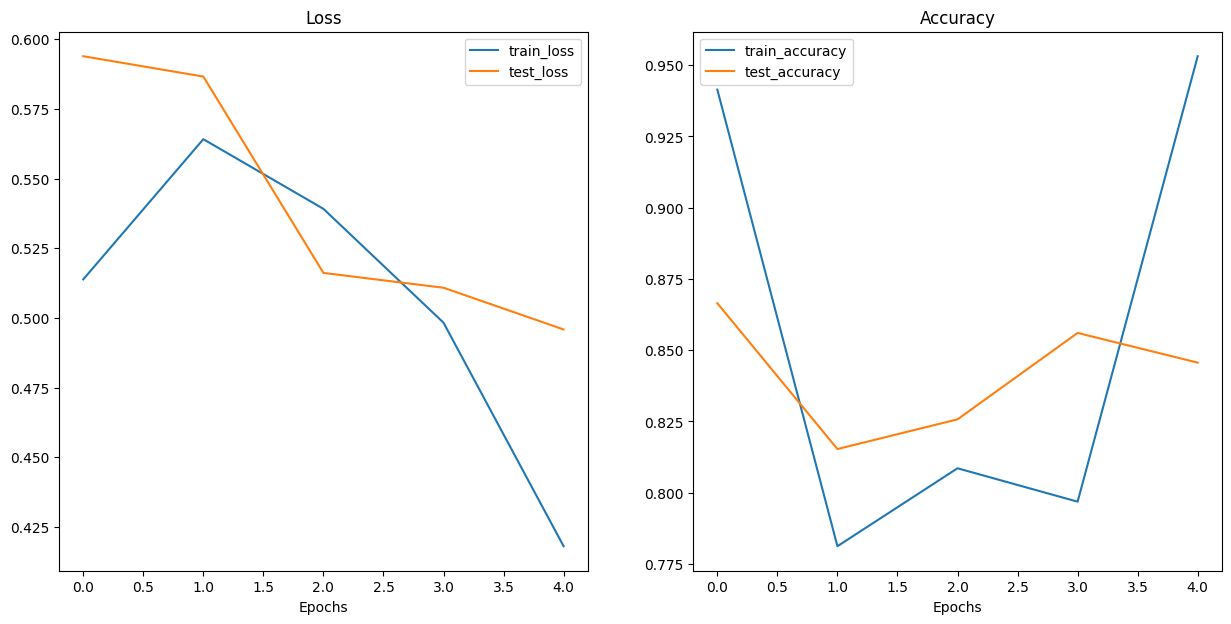

In [33]:
plot_loss_curves(results)

In [35]:
from typing import Tuple,List
from PIL import Image
from torchvision import transforms

def pred_and_plot_image(model:torch.nn.Module,
                        image_path:str,
                        class_names:List[str],
                        image_size: Tuple[int,int]=(224,224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):

  img = Image.open(image_path)

  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225])
    ])

  model.to(device)

  model.eval()
  with torch.inference_mode():
    transformed_image = image_transform(img).unsqueeze(dim=0)
    target_image_pred = model(transformed_image.to(device))

  target_image_pred_probs = torch.softmax(target_image_pred,dim=1)
  target_image_pred_label = torch.argmax(target_image_pred_probs,dim=1)

  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);


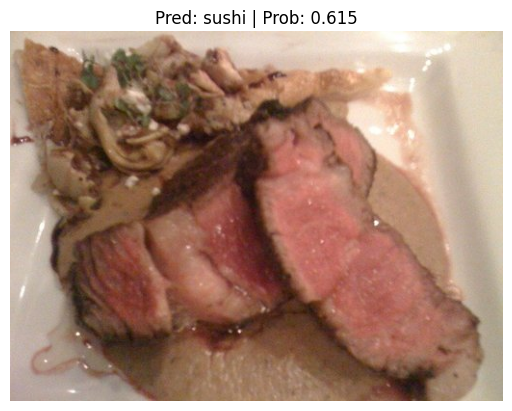

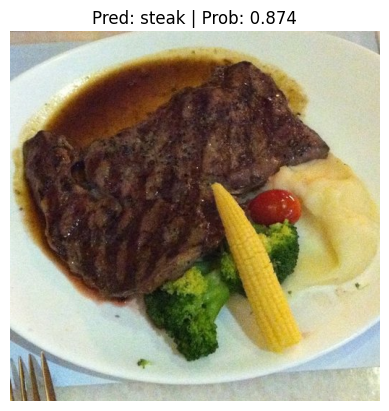

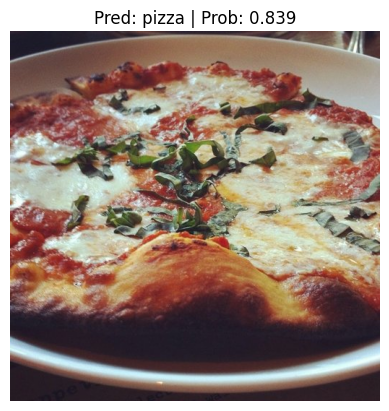

In [38]:
import random
num_image_to_plot = 3
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_image_to_plot)

for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224,224))


In [41]:
import requests
custom_image_path = data_path/'04-pizza-dad.jpeg'

if not custom_image_path.is_file():
  with open(custom_image_path,'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg')
    print(f"Downloading custom image to {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists")

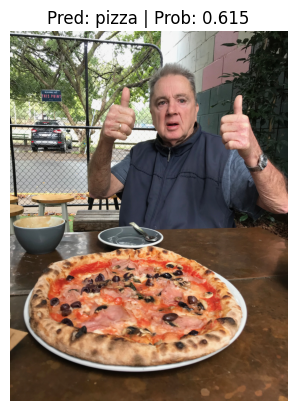

In [42]:
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)